# Проект по исследованию возможностей снижения расходов на невыгодные источники трафика.

В данном проекте мы будет вычислять и высчитывать основные метрические показатели для различным сфер, проверять гипотезы и постараться выявить невыгодные источники трафика для снижения расходов на них. Для ознакомления, данные которые будут затронуты в проекте.

Три датасета.

<span style="color:red"></span>
Файл <span style="color:red">visits_log.csv</span> -  хранит лог сервера с информацией о посещениях сайта. 
Структура visits_log.csv
Uid — уникальный идентификатор пользователя,
Device — категория устройства пользователя,
Start Ts — дата и время начала сессии,
End Ts — дата и время окончания сессии,
Source Id — идентификатор источника перехода на сайт.

Файл <span style="color:blue">orders_log.csv</span> — хранит информацию о заказах.
Структура orders_log.csv
Uid — уникальный идентификатор пользователя,
Buy Ts — дата и время заказа,
Revenue — сумма заказа.


Файл <span style="color:green">costs.csv</span> — хранит информацию о расходах на маркетинг.
Структура costs.csv
source_id — идентификатор рекламного источника,
dt — дата проведения рекламной кампании,
costs — расходы на эту кампанию.


Приступим.

## Изучение данных и осмотр

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

Перво наперво, конечно, добавим библиотеки для работы с данными которые пригодяться. И уже от сюда начнем "читать" и обрабатывать файлы перед непосредственной аналитикой и исследованием.

In [47]:
print(display(visits.head()))
print()
print('Размер таблицы:', visits.shape)
print()
visits.info()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


None

Размер таблицы: (359400, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Первая таблица, с визитами. Здесь заметно только несколько недочетов в плане типов данных, на первый взгляд.

In [48]:
print(display(orders.head()))
print()
print('Размер таблицы:', orders.shape)
print()
orders.info()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


None

Размер таблицы: (50415, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Вторая таблица - заказы. Она уже поменьше будет, нежели предыдущая, но все еще с, практически, теми же недочетами в типе данных.

In [49]:
print(display(costs.head()))
print()
print('Размер таблицы:', costs.shape)
print()
costs.info()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


None

Размер таблицы: (2542, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


И третья таблица - затраты. Она здесь небольшая уже совсем, срез видимо. А с типами данных только один столбец на "переработку".

## Предобработка данных

In [50]:
visits.rename(str.lower, axis='columns', inplace=True)
visits['end ts'] = pd.to_datetime(visits['end ts'])
visits['start ts'] = pd.to_datetime(visits['start ts'])
visits['uid'] = visits['uid'].astype('int')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end ts     359400 non-null  datetime64[ns]
 2   source id  359400 non-null  int64         
 3   start ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  int32         
dtypes: datetime64[ns](2), int32(1), int64(1), object(1)
memory usage: 12.3+ MB


Менять типы данных будем так же, по порядку, в каждой таблице. Сначала визиты.

Для удобства сделаем названия колонок с маленькой буквы через конструкцию rename, и поменяем типы данных в столбцах с датами и тип данных в столбце с id юзеров.

In [51]:
orders.rename(str.lower, axis='columns', inplace=True)
orders['buy ts'] = pd.to_datetime(orders['buy ts'])
orders['uid'] = orders['uid'].astype('int')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 984.8 KB


Фактически аналогичным образом мы поступим здесь, в таблице с заказами. Сначала приведем к нижнему регистру названия столбцов, и преобразим столбцы даты и uid.

In [52]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


А в самой малочисленной таблице, с затратами, остается только поменять столбец с датой, и привести егов тип данных datetime.

## Расчет метрик и построение графиков

В данном разделе мы уже начнем, непосредственно, исслежовать разные метрики. 

Но сначала нужно будет посчитать эти метрики, трёх разных  видов:
продуктовые,
метрики электронной коммерции,
маркетинговые.

### Продуктовые метрики

In [53]:
visits['session_year']  = visits['start ts'].dt.year
visits['session_date'] = visits['start ts'].dt.date

visits['visit_week'] = visits['start ts'].astype('datetime64[W]')
visits['visit_month'] = visits['start ts'].astype('datetime64[M]')

visits_dau = visits.groupby(['session_date']).agg({'uid' : 'nunique'})
visits_wau = visits.groupby(['session_year', 'visit_week']).agg({'uid' : 'nunique'})
visits_mau = visits.groupby(['session_year', 'visit_month']).agg({'uid' : 'nunique'})

print('Среднее дневное количество уникальных пользователей:', int(visits_dau.mean()))
print()
print('Среднее недельное количество уникальных пользователей:', int(visits_wau.mean()))
print()
print('Среднее месячное количество уникальных пользователей:', int(visits_mau.mean()))

Среднее дневное количество уникальных пользователей: 907

Среднее недельное количество уникальных пользователей: 5621

Среднее месячное количество уникальных пользователей: 23228


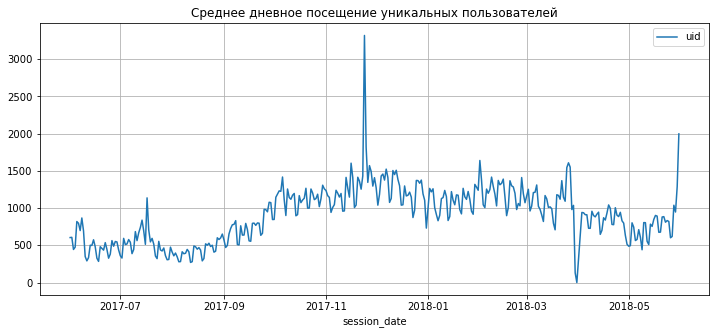

In [54]:
visits_dau_pivot = visits_dau.pivot_table(index='session_date', values='uid')
visits_dau_pivot.plot(y='uid', grid=True, figsize=(12, 5), title='Среднее дневное посещение уникальных пользователей')
plt.show()

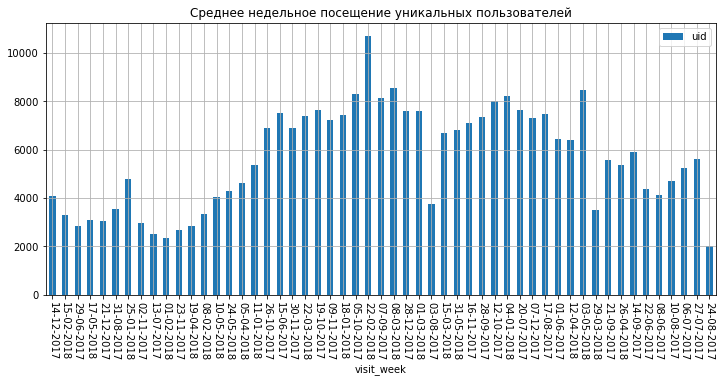

In [55]:
#visits_wau.pivot_table(index='visit_week', values='uid').plot(kind='bar', y='uid', grid=True, figsize=(12, 5), title='Среднее недельное посещение уникальных пользователей')
ax = visits_wau.pivot_table(index='visit_week', values='uid').plot(kind='bar', y='uid', grid=True, figsize=(12, 5), title='Среднее недельное посещение уникальных пользователей')
ax.set_xticklabels(visits['visit_week'].dt.strftime('%d-%m-%Y').unique())
plt.xticks(rotation=-90)
plt.show()

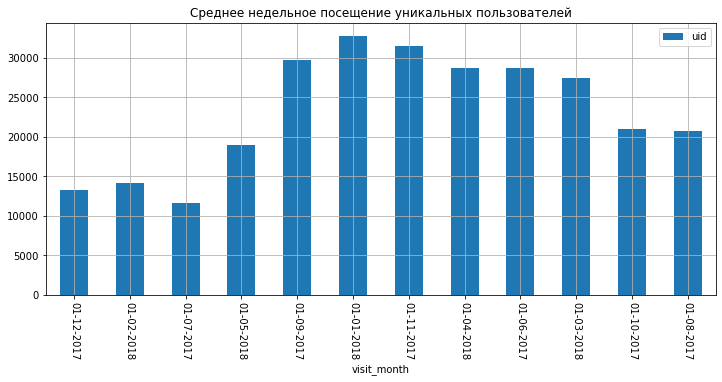

In [56]:
#visits_mau.pivot_table(index='visit_month', values='uid').plot(kind='bar', y='uid', grid=True, figsize=(12, 5), title='Среднее недельное посещение уникальных пользователей')
ax = visits_mau.pivot_table(index='visit_month', values='uid').plot(kind='bar', y='uid', grid=True, figsize=(12, 5), title='Среднее недельное посещение уникальных пользователей')
ax.set_xticklabels(visits['visit_month'].dt.strftime('%d-%m-%Y').unique())
plt.xticks(rotation=-90)
plt.show()

И так, мы вычисили 3 важные продуктовые метрики посещения дневного, недельного, месячного уникальных пользователей на сайт. Метрики соответственно DAU, WAU, MAU. Для каждой из них так же можно увидеть распределение по каждому временному "критерию". В каждом графике есть закономерность возрастания пользователей к Новому году, что не удивительно. Так же, дальше построим и посмотрим сколько в среднем пользователей заходят на сайт в день(не только уникальных). И увидим как часто пользователи перезаходят на сайт.

In [57]:
count_visits = visits.groupby('session_date').agg({'uid' : 'count'}).mean()
print('Среднее количество пользователей в день:', int(count_visits))

Среднее количество пользователей в день: 987


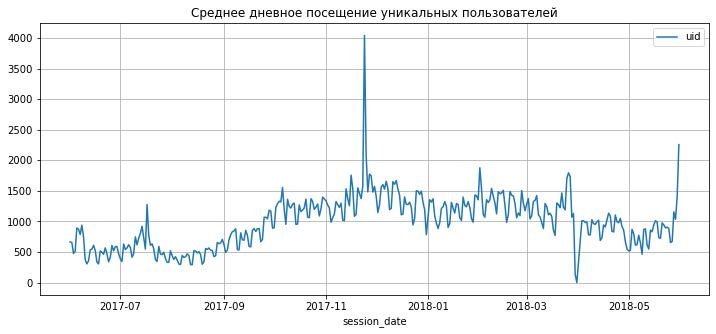

In [58]:
visits.pivot_table(index='session_date', values='uid', aggfunc='count').plot(y='uid', grid=True, figsize=(12, 5), title='Среднее дневное посещение уникальных пользователей')
plt.show()

Как видно, числа уникальных пользователей и повторных, практически не отличаются, хотя тенденции остаются практически одни и те же. Это должно быть с чем то связано.

Теперь, выясним, сколько пользователь проводит на сайте времени в среднем, или иными словами, сколько длиться средняя сессия.

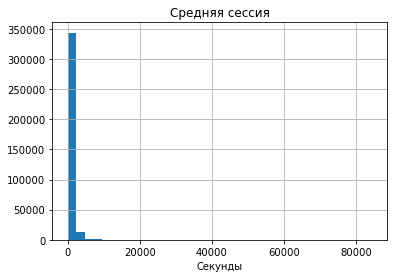

0    60
dtype: int64


In [59]:
visits['session_in_sec'] = (visits['end ts'] - visits['start ts']).dt.seconds

plt.title('Средняя сессия')
visits['session_in_sec'].hist(bins=35)
plt.xlabel('Секунды')
plt.show()
asl = visits['session_in_sec'].mode()
print(asl)

Распределение конечно не самое нормальное, вероятно здесь какое то определенное число секунд доминирует в среднем. Здесь вероятно стоит применить метод mode, для определения самого популярного значения - и это 60 секунд

In [60]:
first_visit_date = visits.groupby(['uid'])['start ts'].min()
 
first_visit_date.name = 'first_visit_date'
visits = visits.merge(first_visit_date,on='uid', how='left') 
 
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]') 
 
visits['cohort_lifetime'] = visits['visit_month'] - visits['first_visit_month']
visits['cohort_lifetime'] = (visits['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype('int')
 
cohorts_visits = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
 
initial_users_count = cohorts_visits[cohorts_visits['cohort_lifetime'] == 0][['first_visit_month', 'uid']]
initial_users_count = initial_users_count.rename(columns = {'uid' : 'cohort_users'})
 
cohorts_visits = cohorts_visits.merge(initial_users_count,on='first_visit_month') 
cohorts_visits['retention'] = cohorts_visits['uid'] / cohorts_visits['cohort_users']
retention_pivot = cohorts_visits.pivot_table(index='first_visit_month', columns='cohort_lifetime', values='retention', aggfunc='sum')

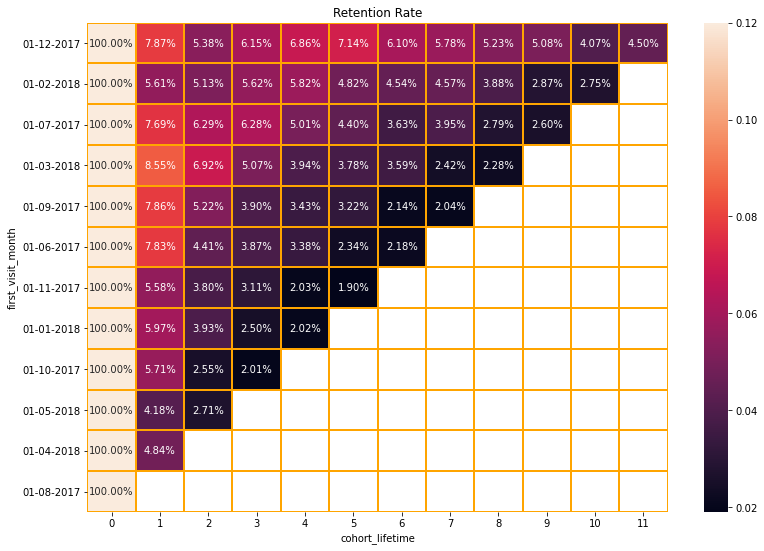

In [61]:
plt.figure(figsize=(13, 9))
plt.title('Retention Rate')
ax = sns.heatmap(retention_pivot, vmax=0.12,annot=True, fmt='.2%', linewidths=1, linecolor='orange')
ax.set_yticklabels(visits['first_visit_month'].dt.strftime('%d-%m-%Y').unique())
plt.show()

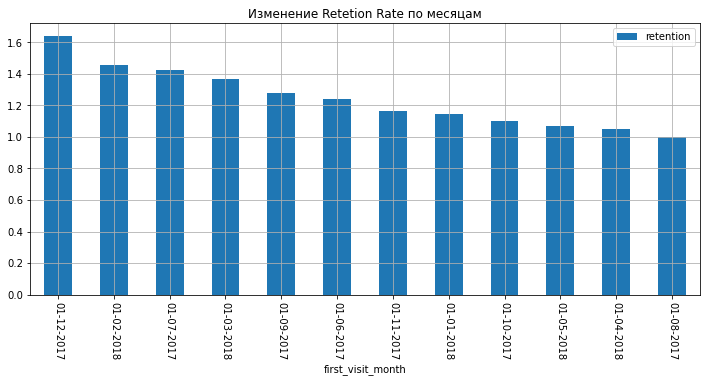

In [62]:
ax = cohorts_visits.pivot_table(index='first_visit_month', values='retention', aggfunc='sum').plot(kind='bar', y='retention', grid=True, figsize=(12, 5), title='Изменение Retetion Rate по месяцам')
ax.set_xticklabels(visits['first_visit_month'].dt.strftime('%d-%m-%Y').unique())
plt.xticks(rotation=-90)
plt.show()

In [63]:
ch1 = cohorts_visits.query('cohort_lifetime != 0')

print('Средний Retetion Rate со вторых месяцев: {:.2%}' .format(ch1['retention'].mean()))

Средний Retetion Rate со вторых месяцев: 4.45%


Ну и наконец показатель Retention Rate, возможно самый важный зачастую. 
Как можно увидеть, он чрезвычайно низок. В среднем показатель на второй месяце падает до 4.45%, что не может быть хорошо, а дальше не лучше. Да и по месяцам видно как сам показатель медленно, но верно падает все ниже и ниже. Не хорошо.

<hr style="border: 1px solid #000;"> 

<div class="alert alert-success">
<strong><font size=5>Комментарий от ревьюера</font></strong><br/>
    
Хороший дополнительный график с суммарным Retention. Довольно показательно.
    
</div>
<hr style="border: 1px solid #000;"> 

### Метрики электронной комерции

In [64]:
orders_grouped = orders.merge(first_visit_date, on='uid', how='left')

orders_grouped['time_to_buy'] = (orders_grouped['buy ts'] - orders_grouped['first_visit_date']).dt.seconds
orders_not_null = orders_grouped.query('time_to_buy != "0"')
print('Среднее время с момента первого посещения до совершения покупки:', int(orders_not_null['time_to_buy'].mode()),'секунд')

Среднее время с момента первого посещения до совершения покупки: 60 секунд


Сперва выяснили какое среднее время занимает у людей от начала сессии до совершения покупки(использовался метод mode во избежание аномалий завышеных.). И как выяснилось, что чаще всего люди находятся около минуты в сайте, что может говорить о том, что покупатели уже конкретно знают за чем идет, что, вероятно не будет очень хорошим показателем.

In [65]:
orders['buy_year']  = orders['buy ts'].dt.year
orders['buy_month'] = orders['buy ts'].dt.month.round()
orders['buy_date'] = orders['buy ts'].dt.date
orders_query = orders.query('buy_year != 2018 and buy_month != 6')

print((orders_query.groupby(['buy ts']).agg({'uid' : 'nunique'})).mean())


uid    1.098316
dtype: float64


Так же, выяснили и среднее количество покупок за шесть месяцев, и как показывает подсчет, чаще всего покупают что то одно.

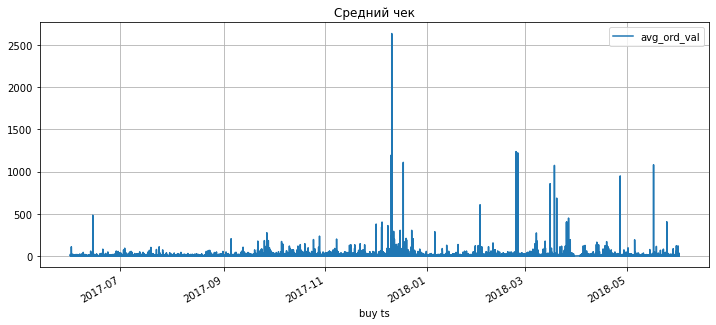

In [66]:
orders_aov = orders.groupby('buy ts').agg({'revenue' : 'sum', 'buy ts' : 'count'})
orders_aov['avg_ord_val'] = orders_aov['revenue'] / orders_aov['buy ts']
orders_aov = orders_aov.rename(columns = {'revenue' : 'ord_sum', 'buy ts' : 'ord_count'})
orders_aov.pivot_table(index='buy ts', values='avg_ord_val').plot(y='avg_ord_val', grid=True, figsize=(12, 5), title='Средний чек')
plt.show()

На очереди средний чек по покупкам и как он изменялся по времени. Как видно на графике, средний чек скакал примерно в те периоды, когда были какие либо события, где люди покупают в огромных количествах.

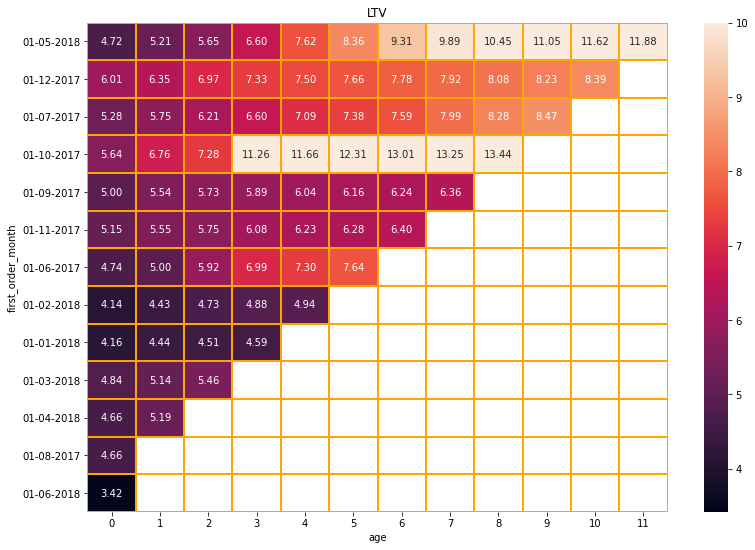

In [68]:

orders['order_month'] = orders['buy ts'].astype('datetime64[M]')
costs['month'] = costs['dt'].astype('datetime64[M]')

first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

orders_new = pd.merge(orders,first_orders, on='uid')

cohorts = orders_new.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()

report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

margin_rate = 1

report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']

result = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')

cum_ltv = result.cumsum(axis=1)

plt.figure(figsize=(13, 9))
plt.title('LTV')
ax = sns.heatmap(cum_ltv, vmax=10, annot=True, fmt='.2f', linewidths=1, linecolor='orange')
ax.set_yticklabels(first_orders['first_order_month'].dt.strftime('%d-%m-%Y').unique())
plt.show()

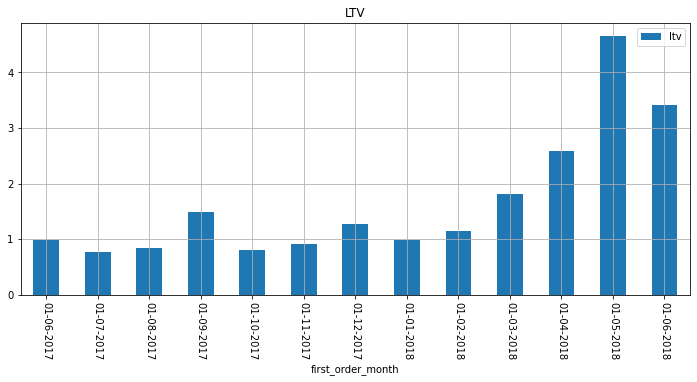

In [70]:
ax = report.pivot_table(index='first_order_month', values='ltv').plot(kind='bar', y='ltv', grid=True, figsize=(12, 5), title='LTV')
ax.set_xticklabels(report['first_order_month'].dt.strftime('%d-%m-%Y').unique())
plt.xticks(rotation=-90)
plt.show()

In [71]:
m6_cum_ltv = result.cumsum(axis=1).mean(axis=0)[6]

print('Средний LTV за 6 месяцев:', m6_cum_ltv)

Средний LTV за 6 месяцев: 8.387686429758398


И наконец LTV, ценность клиента, если можно так выразиться.
Здесь этот показатель сильно варьировался в течении месяцев, что можно видеть как на графике, так и на таблице. 

Тенденция этого показателя держится относительно высоко только в первых когортах, что говорит о каких то некачественных изменениях за последние 6 месяцев.

НО, самое важно что здесь можно вынести я думаю, это то, что LTV растет! Причем в последние месяцы достаточно скачкообразно.  Только со временем, порядка 6 месяцев чтобы перебить нынешнее среднее. Стоит это учитывать в будущем.

А сам средний показатель LTV держиться на почти 8.5

### Маркетинговые метрики

In [72]:
print('Cуммарные расходы на маркетинг:', int(costs['costs'].sum()))

Cуммарные расходы на маркетинг: 329131


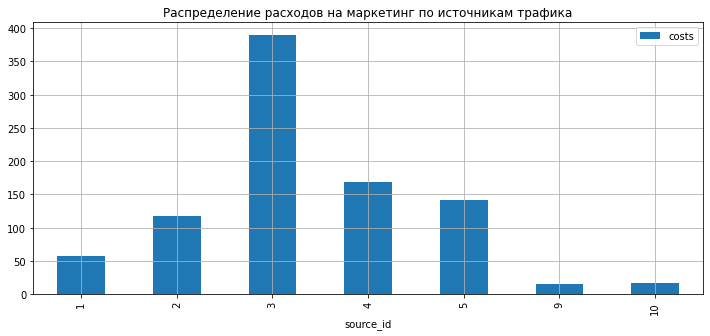

In [73]:
costs.pivot_table(index='source_id', values='costs').plot(kind='bar', y='costs', grid=True, figsize=(12, 5), title='Распределение расходов на маркетинг по источникам трафика')
plt.show()

Так так, интересное распределение. Как видно, по источникам трафика, почти половина всех расходов занимает трафик номер 3. дальше оставшуюся часть занимают трафики 4,5 и так далее. Будем изучать.

In [74]:
month_costs = costs.groupby(['month']).sum()

report_new = pd.merge(report, month_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

In [75]:
print('Средний CAC на покупателя:', report_new['cac'].mean())

Средний CAC на покупателя: 9.319905176921111


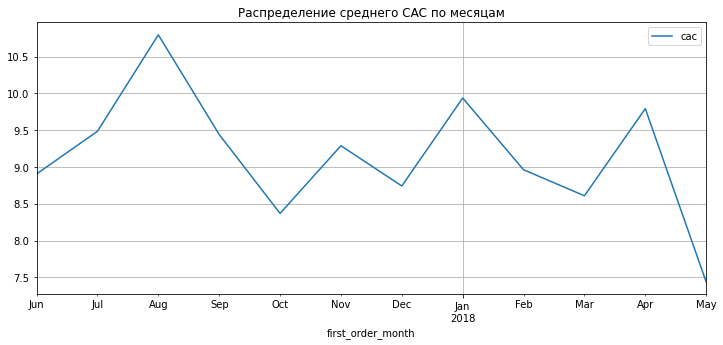

In [76]:
report_new.pivot_table(index='first_order_month', values='cac').plot(y='cac', grid=True, figsize=(12, 5), title='Распределение среднего CAC по месяцам')
plt.show()

<hr style="border: 1px solid #000;"> 

<div class="alert alert-warning">
<strong><font size=5>Комментарий от ревьюера (v.3)</font></strong><br/>
    
Выше ошибка в самой первой строке:
```python
first_source = visits.sort_values(by='start ts', ascending=False).groupby('uid').agg({'source id':'min'}).reset_index()
```
    
Мы сортируем датафрейм по `start ts` в порядке возрастания, чтобы взять первый элемент (методом first), а не чтобы взять минимальное значение рекламного источника. Минимальное не равно первое. Я поправлю на `first()`.
    
Что ещё не совсем корректно, это вот эта строка:
```python
cohort_siz = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
```
Мы тут считаем размеры когорт, но почему-то группируем по месяцу первой покупки. Но мы ведь считаем в разрезе ещё и рекламных источников. А тут получается, что мы посчитали когорты, появившиеся на определённый месяц по всем рекламным источникам суммарно, а потом к этому джойним информацию в разрезе источников.
    
Твой вариант решения можно поправить и получить корректные результаты, но я попробую показать немного иной подход, более детальный, но при этом по сложности такой же.

    
</div>

In [83]:
# находим первого источника каждого посетителя
first_source = (visits.sort_values(by='start ts', ascending=False).groupby('uid').agg({'source id':'first'}).reset_index())
first_source.columns = ['uid', 'first_source']
orders_new = orders_new.merge(first_source, on='uid')

<div class="alert alert-warning">
    
Мы помним, что тут мы считаем уже в разбивке по источникам. Поэтому на этом уже этапе создадим цикл, который будет перебирать наши рекламные источники. А мы будем отфильтровывать нужных клиентов (которые пришли по данному рекламному источнику и считать метрики только по ним):
    
</div>

In [85]:
sources_list = sorted(orders_new['first_source'].unique())
sources_list

[1, 2, 3, 4, 5, 7, 9, 10]

In [90]:
for source in sources_list:
    # оставляем только те записи из orders, которые соответствуют текущему источнику
    orders_filtered = orders_new.query('first_source == @source')
    # display(orders_filtered)


   
    
    # считаем возраст каждой когорты
    cohorts['age'] = ((cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1,'M')).round().astype(int)
    cohorts.columns = ['first_order_month', 'order_month', 'revenue', 'age']
    
    
    
    # Добавляем в когортный отчет количество покупателей в каждой когорте и считаем LTV
    cohorts_report = pd.merge(cohort_sizes, cohorts, on = 'first_order_month')
    cohorts_report['ltv'] = cohorts_report['revenue'] / cohorts_report['n_buyers']
    
    # display(cohorts_report)
    
    # посчитаем затраты и выберем затраты по нужному источнику
    source_costs = costs.groupby(['source_id', 'dt']).sum().reset_index()
    source_costs_filtered = source_costs_test.query("source_id == @source").drop('source_id', axis=1)
    # display(source_costs_test_filtered)
    
    cohorts_report_full = cohorts_report.merge(source_costs_filtered, 
                                               left_on='first_order_month',
                                               right_on='dt')
    
    # display(cohorts_report_full)
    
    # считаем САС
    cohorts_report_full['cac'] = cohorts_report_full['costs'] / cohorts_report_full['n_buyers']
    
    # считаем ROMI
    cohorts_report_full['romi'] = cohorts_report_full['ltv'] / cohorts_report_full['cac']

    # display(cohorts_report_full)
    
    # убираем нули из подписей по Oy
    cohorts_report_full['first_order_month'] = cohorts_report_full['first_order_month'].dt.strftime('%Y-%m')
    
    # финальная сводная
    output_final = cohorts_report_full.pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean'
    )
    # если она пустая, то идём дальше - считаем следующий источник
    # (пустая будет по 7 источнику - по нему нет затрат на рекламу)
    if not len(output_final):
        continue
        
    # display(output_final)
     
    # рисуем график
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title(f'ROMI для когорт пользователей (по источнику {source})')
    sns.heatmap(output_final.cumsum(axis=1).round(2) , annot=True, fmt='.1%', linewidths=1, linecolor='gray')

NameError: name 'source_costs_test' is not defined

<div class="alert alert-warning">
    
Тут мы по каждому источнику рекламы делаем когортый анализ. И можем увидеть, какая из когорт показала какой ROMI.
    
</div>
<hr style="border: 1px solid #000;"> 

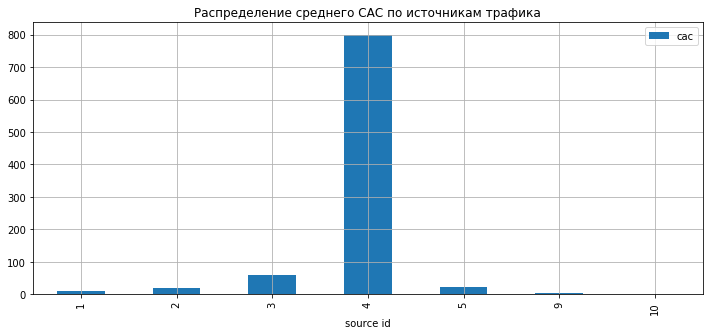

In [57]:
report_source_new.pivot_table(index='source id', values='cac').plot(kind='bar', y='cac', grid=True, figsize=(12, 5), title='Распределение среднего CAC по источникам трафика')
plt.show()

Далее параметр CAС, или "стоимость" одного нового клиента для компании. В среднем этот показатель на одного клиента обходиться примерно в районе 9.
Далее уже средние распределения по месяцам, которые варьируются в зависимости от событий в мире. Странное то, что в августе месяце он был достаточно завышен, хотя и в начале периода выбранного тот же LTV был не так упадок как это позже произошло. Видимо закономерно.

И наконец самое интересное, это CAC по источникам трафика, и нас, конечно же интересует номер 4, самый затратный из них. Он практически полностью, вместе с 3-им перевешивают остальное. Это говорит о срочной переработке стратегии маркетинговой.

In [36]:
report_source_new[report_source_new['source id'] == 1]

,first_order_month,new_buyers,source id,order_month,rev_sum,rev_uniq,gp,age,ltv,costs,cac,romi
0,2017-06-01,2023,1,2017-06-01,2563.84,119,2563.84,0,1.267346,20833.27,10.298206,0.123065
1,2017-06-01,2023,1,2017-07-01,881.60,58,881.60,1,0.435788,20833.27,10.298206,0.042317
2,2017-06-01,2023,1,2017-08-01,755.03,60,755.03,2,0.373223,20833.27,10.298206,0.036242
3,2017-06-01,2023,1,2017-09-01,1783.91,85,1783.91,3,0.881814,20833.27,10.298206,0.085628
4,2017-06-01,2023,1,2017-10-01,1884.06,97,1884.06,4,0.931320,20833.27,10.298206,0.090435
...,...,...,...,...,...,...,...,...,...,...,...,...
73,2018-03-01,3533,1,2018-04-01,888.33,60,888.33,1,0.251438,20833.27,5.896765,0.042640
74,2018-03-01,3533,1,2018-05-01,960.91,51,960.91,2,0.271981,20833.27,5.896765,0.046124
75,2018-04-01,2276,1,2018-04-01,2578.35,118,2578.35,0,1.132843,20833.27,9.153458,0.123761
76,2018-04-01,2276,1,2018-05-01,992.40,61,992.40,1,0.436028,20833.27,9.153458,0.047635


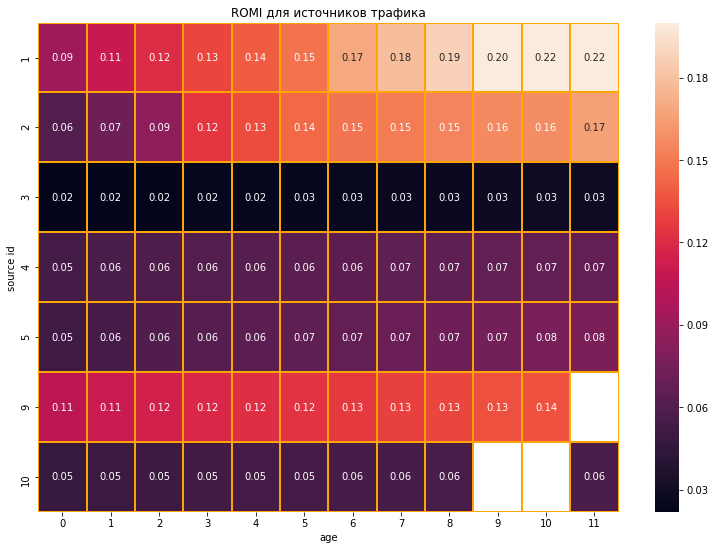

In [58]:
report_source_new['romi'] = report_source_new['ltv'] / report_source_new['cac']

output = report_source_new.pivot_table(index='source id', columns='age', values='romi', aggfunc='mean')

cum_romi = output.cumsum(axis=1)

plt.figure(figsize=(13, 9))
plt.title('ROMI для источников трафика')
ax = sns.heatmap(cum_romi, vmax=0.2, annot=True, fmt='.2f', linewidths=1, linecolor='orange')
plt.show()

<hr style="border: 1px solid #000;"> 

<div class="alert alert-danger">
<strong><font size=5>Комментарий от ревьюера</font></strong><br/>
    
Логика расчётов выглядит верной. Осталось пересчитать LTV. А то у нас ROMI 3000. А должно быть максимум несколько единиц.
    
</div>
<hr style="border: 1px solid #000;"> 

<hr style="border: 1px solid #000;"> 

<div class="alert alert-danger">
<strong><font size=5>Комментарий от ревьюера (v.2)</font></strong><br/>
    
Здесь немного не так. В `report_temp` ты считаешь ROMI на каждый день, при этом размерность когорт у нас месячная (то есть в первой когорте в первом месяце было 2023 клиента, и пришли они в течение всего первого месяца). А в output потом средний показатель за месяц. Поэтому и САС, и ROMI нам нужно считать за месяц.
    
</div>
<hr style="border: 1px solid #000;"> 

<div class="alert alert-info">
Я наконец понял что для подсчета показателей по источникам трафика нужно было и LTV для него же посчитать. Надеюсь правильно исправил
<div>

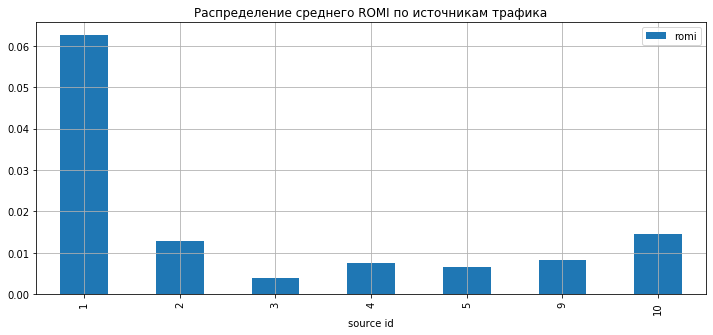

In [33]:
report_source_new.pivot_table(index='source id', values='romi').plot(kind='bar', y='romi', grid=True, figsize=(12, 5), title='Распределение среднего ROMI по источникам трафика')
plt.show()

Изучим же окупаемость по источникам трафика. Что показают нам данные и графики. 

Если смотреть по месяцам жизни когорт, достаточно ярко выделяется 1 источник трафика, где показатель ROMI только растет со временем практически из месяца в месяц. И так же, достаточно ярко выделяются те самые  3 и 4 в особенности(с баснословными показателями CAC) источники трафика. Здесь уже обратимся к графику.

Видно, что самым низким среднем значением ROMI является 3, и рядом 4 источник, который больше всего тянут средства из компании.

## Вывод

Сперва, стоит обративть пристальное внимание на 3 и 4 источник трафика, который показывает не самые лучшие результаты по метрикам ROMI и CAC. Вероятно в сфере источников, стоило бы немного сменить вектор на сторону 1 и возможно 2 трафиков, т.к последний показывал неплохую так же тенденцию по сравнению с другими. Тут уже картина как по месяцам, так и по CAC, что не маловажно, показывает что в них стоит вкладываться, потенциал велик и окупаемость на высочацшем уровне.

Далее по группам метрик.

В Retenrion Rate в особенности в сфере продуктовых метрик, явно стоит что то делать, т.к. показатель на достаточно низком уровне, он продолжает безостановочно падать с кажым месяцем, и среднее время на сайте у людей не самое большое. Возможно дело с дизайном или интерфейсом сайта, тут стоит разобраться поглубже.

Следом электронная коммерция. Тут дела обстоят 50 на 50 вероятно. Показатели CTR не самые лучшие, тут вэб-дизайнерам я думаю стоит улучшить что то, о чем еще говорит среднее время на сайте от начала сесси до покупки. Чаще всего люди не проводят время, выбирая что то на сайте как в розничном магазине, и от сюда вероятно проблемы с CTR. Но стоит заметить, что по показателю среднему LTV тут не так все плохо, в самых ранних когортах за выбранны период показатель держиться довольно высоко, даже с некоторыми положительными аномалиями. Но сама тенденция по дальнейшим когортам не самая радужная. Спасают сезоны, в которых LTV скачет вверх.

Ну и маркетинговые показатели м метрки. Тут, как я уже в кратце выражался выше, стоит перестроить модель затрат на источники трафика. Вполне возможно, все проблемы сайта по различным метрикам и кроются в этом, и если уделить больше внимания 1-чке и 10-ке, то будет выхлоп.

И на последок, так что стоит сказать по когортам, которые практически везде, были выделены одни и те же. По моему мнению, пока маркетинговая политика не перемениться, стоит уделять больше времени на работу с новыми клиентами, и удерживать самых старых. Самые первые когорты, даже спустя столько времени остаются самыми прибыльными для бизнесса. Но и в некоторых новых нельзя не заметить положительные тенденции по некоторым метрикам.

<hr style="border: 1px solid #000;"> 

<div class="alert alert-success">
<strong><font size=5>Комментарий от ревьюера</font></strong><br/>
    
Выводы отличные. Очень хорошие рассуждения. И что немаловажно - всё грамотно.
    
</div>
<hr style="border: 1px solid #000;"> 

<div class="alert alert-info">
Спасибо за внимание, надеюсь я работал в правильном направлении, и желаю хорошего дня(вечера) мистер(или мисс(ис)) ревьюер :) </div>

<div class="alert alert-info">
P.S. 
Свои комментарии по исправлениям я буду писать в такой рамке, если нет возражений)<div>

<hr style="border: 1px solid #000;"> 

<div>
<strong><font size=5>Комментарий от ревьюера</font></strong><br/>
    
Основную часть работы мы сделали. Осталось ещё немного проработать качественные замечания и пересчитать LTV.
    
Жду твою работу на повторную проверку.
    
</div>
<hr style="border: 1px solid #000;"> 

<hr style="border: 1px solid #000;"> 

<div>
<strong><font size=5>Комментарий от ревьюера (v.2)</font></strong><br/>
    
Большую часть поправили. Осталось ещё немного. Скоро добьём.
    
Жду на повторную проверку.
    
</div>
<hr style="border: 1px solid #000;"> 

<hr style="border: 1px solid #000;"> 

<div class="alert alert-success">
<strong><font size=5>Комментарий от ревьюера (v.3)</font></strong><br/>
    
Теперь со всем разобрались. Работу принимаю.
    
Жду тебя на следующих проектах.
    
</div>
<hr style="border: 1px solid #000;"> 